### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [154]:
# PCA source: Week 2 slides - Manifold Learning

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
l = data['l'].flatten()  # image Labels (1,520)

In [155]:
# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def partition_dataset_8_2(data):
    X = data['X'] # flat images dim (2576,520)
    l = data['l'].flatten()  # image Labels (1,520)
    X_train, Y_train, X_labels, Y_labels  = [], [], [], []
    for i in range(0, 520, 10):
        im_train, im_test, l_train, l_test = train_test_split( X[:, i: i + 10].T, l[i: i + 10], test_size=0.2, random_state=42)
        X_train.append(im_train)    
        Y_train.append(im_test)  
        X_labels.append(l_train)  
        Y_labels.append(l_test)  
    X_train = np.array(X_train).reshape(-1, 2576)
    Y_train = np.array(Y_train).reshape(-1, 2576)
    X_labels = np.array(X_labels).reshape(-1)
    Y_labels = np.array(Y_labels).reshape(-1)
    return  X_train, Y_train, X_labels, Y_labels

X_train, Y_train, X_labels, Y_labels = partition_dataset_8_2(data)
print( X_train.shape, Y_train.shape, X_labels.shape, Y_labels.shape)

(416, 2576) (104, 2576) (416,) (104,)


In [156]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def PCA(A,N):
    S = (1/N) * np.dot(A, A.T)
    return get_sorted_eigen(S)

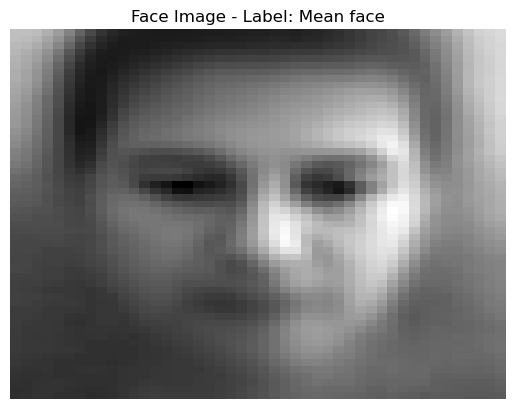

None


In [157]:
X_train_mean = np.mean(X_train, axis=0)
A = X_train - X_train_mean
N = A.shape[1]
print(display_image(X_train_mean, "Mean face"))

In [158]:
# They cannot possibly be the same since they have different dimensions. 

##### Look here FELIX - AAT: S = (1/N) A * A^T, ATA: S = (1/N) A^T * A  
eigenvalues_AAT, eigenvectors_AAT = PCA(A,N)
eigenvalues_ATA, eigenvectors_ATA = PCA(A.T,N)
##########